In [14]:
import os
import cv2
import argparse
from sklearn import svm
from skimage import feature, exposure, color
from skimage.feature import hog
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [15]:
# Resizes a image and maintains aspect ratio
def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape[:2]

    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the 0idth and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Return the resized image
    return cv2.resize(image, dim, interpolation=inter)

In [46]:
def hog_it_up(image):
    fd, hog_image = hog(color.rgb2gray(image), orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), channel_axis=None, visualize=True)
#     hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_image_rescaled = exposure.rescale_intensity(hog_image, out_range=(0, 255)).astype("uint8")

    return fd, hog_image_rescaled

In [25]:
x = 450
y = 100
h = 850
w = 700
frame_dim = (1920,1080)
fps = 60
hoggy_images = []
def hog_the_video(input_path):
    cap = cv2.VideoCapture(input_path)
    instance_count = 0
    next_frame = 0
    count = 0
    success = True
    video_fds = []
    video_images = []
    while success:
        success, frame = cap.read()
        if count % fps == 0 and success:
#             if frame.shape[0] > 1080 and frame.shape[1] > 1920:
#                 frame = maintain_aspect_ratio_resize(frame.copy(), width=frame_dim[0], height=frame_dim[1])
        
            cropped_frame = frame.copy()[y:y+h, x:x+w]
#             cropped_resized_frame = maintain_aspect_ratio_resize(cropped_frame, width=256)
            
            # TODO: test impacts of gaus blur
            cropped_resized_blurred_frame = cv2.GaussianBlur(cropped_frame,(3,3),0)
            
#             cropped_blurred_frame_forced_size = cv2.resize(blur, (512, 512))

            fd, hoggy_cropped_frame = hog_it_up(cropped_resized_blurred_frame)
            hoggy_images.append(hoggy_cropped_frame)
#             video_fds.append(fd)
#             video_images.append(hoggy_cropped_frame)
            video_images.append(cropped_resized_blurred_frame)

        count+=1
    
    cap.release()
    cv2.destroyAllWindows()
    return video_fds, video_images


In [26]:
### iterate over raw video inputs, select images throughout video, get the hog feature descriptors & images 
all_images = []
all_fds = []
all_labels = []
video_paths = os.listdir(f"./raw")
for path in video_paths:
    all_videos = os.listdir(f"raw/{path}")
    for video in all_videos:
        video_path = f"./raw/{path}/{video}"
        print('video_path: ', video_path)

#         fds, images = hog_the_video(video_path)
        fds, images = hog_the_video(video_path)
    
        print(path)
        all_images = all_images + images
        all_fds = all_fds + fds
        all_labels = all_labels + [path] * len(images)

video_path:  ./raw/baby/blanket1.mp4
baby
video_path:  ./raw/baby/blanket2.mp4
baby
video_path:  ./raw/baby/blanket3.mp4
baby
video_path:  ./raw/baby/blanket4.mp4
baby
video_path:  ./raw/baby/blanket5.mp4
baby
video_path:  ./raw/baby/blanket6.mp4
baby
video_path:  ./raw/baby/blanket7.mp4
baby
video_path:  ./raw/baby/blanket8.mp4
baby
video_path:  ./raw/baby/blanket9.mp4
baby
video_path:  ./raw/no_baby/nobaby1.mp4
no_baby
video_path:  ./raw/no_baby/nobaby2.mp4
no_baby
video_path:  ./raw/no_baby/nobaby3.mp4
no_baby
video_path:  ./raw/no_baby/nobaby4.mp4
no_baby
video_path:  ./raw/no_baby/nobaby5.mp4
no_baby
video_path:  ./raw/no_baby/nobaby6.mp4
no_baby


In [ ]:
# HOG IMAGE MODEL CLASSIFIER
print('Training...')

X_train, X_test, y_train, y_test = train_test_split(all_fds, all_labels, test_size=0.2, stratify=all_labels)
print('test: ', len(X_train), len(X_test), len(y_train), len(y_test))

clf = svm.SVC(probability=True)

print('images, labels, fds: ', len(all_images), len(all_labels), len(all_fds))
# print(len(all_fds[0]))
clf.fit(X_train, y_train)

shape:  (850, 700, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(68, 1785000)
(1785000,)
test:  54 14 54 14


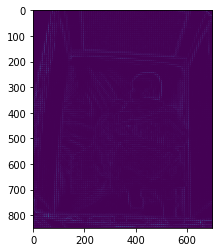

In [48]:
# RAW IMAGE MODEL CLASSIFIER
import numpy as np

# test_gray = color.rgb2gray(all_images[0])
print('shape: ', all_images[0].shape)

# from PIL import Image
# im = Image.fromarray(hoggy_images[2])
# im = im.convert('L')
# im.save("your_file.png")

im = hog_it_up(all_images[3])[1]
# im.convert('RGB')
print(im)
plt.imshow(im)
im = Image.fromarray(im)
im.save("your_file.png")

im = Image.fromarray(all_images[3])
im.save("your_file2.png")

# plt.imshow(all_images[3])
flat_data_arr = []
for img in all_images:
    flat_data_arr.append(img.flatten())
    
flat_data = np.array(flat_data_arr)
print(flat_data.shape)
print(flat_data[0].shape)


X_train, X_test, y_train, y_test = train_test_split(flat_data, all_labels, test_size=0.2, stratify=all_labels)
print('test: ', len(X_train), len(X_test), len(y_train), len(y_test))

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc = svm.SVC(probability=True)
model = GridSearchCV(svc, param_grid)

clf = svm.SVC(probability=True)

print('images, labels: ', len(all_images), len(all_labels))
print(len(all_images[0]))
model.fit(X_train, y_train)

images, labels:  68 68
310


GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [26]:
model.best_params_

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}

In [11]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
print('y_proba: ', y_proba)

print(y_pred)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

y_proba:  [[0.97445412 0.02554588]
 [0.06737374 0.93262626]
 [0.97412012 0.02587988]
 [0.97406685 0.02593315]
 [0.0678785  0.9321215 ]
 [0.97432558 0.02567442]
 [0.03957709 0.96042291]
 [0.93827725 0.06172275]
 [0.91477796 0.08522204]
 [0.06917004 0.93082996]
 [0.97145624 0.02854376]
 [0.97433275 0.02566725]
 [0.9738429  0.0261571 ]
 [0.04005408 0.95994592]]
['baby' 'no_baby' 'baby' 'baby' 'no_baby' 'baby' 'no_baby' 'baby' 'baby'
 'no_baby' 'baby' 'baby' 'baby' 'no_baby']
Accuracy: 1.0


              precision    recall  f1-score   support

        baby       1.00      1.00      1.00         9
     no_baby       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [ ]:
import pickle

final_clf = svm.SVC(probability=True, C=0.1, gamma=0.0001, kernel='poly')
print(final_clf)
print('len: ', len(all_images))
final_clf.fit(flat_data, all_labels)

with open('creepy_baby_model.pkl','wb') as f:
    pickle.dump(final_clf,f)